## Setup

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.status()

  Activating project at `~/WignerMolecule.jl/analysis`


Status `~/WignerMolecule.jl/analysis/Project.toml`
  [13f3f980] CairoMakie v0.15.8
⌃ [780c37f4] Carlo v0.2.6
  [074ae576] CarloAnalysis v1.0.0-DEV `https://github.com/PatXue/CarloAnalysis.jl#main`
  [a93c6f00] DataFrames v1.8.1
  [f67ccb44] HDF5 v0.17.2
  [033835bb] JLD2 v0.6.3
  [ebeed567] PeriodicArrays v0.1.0 `https://github.com/PatXue/PeriodicArrays.jl#main`
  [90137ffa] StaticArrays v1.9.16
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using CairoMakie
using Carlo.ResultTools
using CarloAnalysis
using DataFrames
using HDF5
using JLD2
using LinearAlgebra
using PeriodicArrays
using StaticArrays

In [3]:
function etak_tranform(etak_corrs)
    result = map(Iterators.product(1:3, 1:3)) do (x, y)
        etak_corrs[:, :, x, y]
    end
    return reshape(result, (9,))
end

Γ(corrs) = abs.(getindex.(corrs, 1, 1))
function M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 2)+1, 1])
    end
    return Ms
end
function half_M(corrs)
    Ms = Vector(undef, length(corrs))
    for i in eachindex(corrs)
        Lx, Ly = size(corrs[i])
        Ms[i] = abs(corrs[i][div(Lx, 4)+1, 1])
    end
    return Ms
end

function separate_etaks!(data::AbstractDataFrame)
    col_names = [:ηk_xx, :ηk_yx, :ηk_zx, :ηk_xy, :ηk_yy, :ηk_zy, :ηk_xz, :ηk_yz, :ηk_zz]
    select!(
        data,
        Not(:etak_corrs),
        :etak_corrs => (corrs -> etak_tranform.(corrs)) => col_names,
    )
    transform!(
        data,
        col_names .=> Γ,
        col_names .=> M,
        col_names .=> half_M
    )
    return nothing
end

function separate_spinks!(data::AbstractDataFrame)
    transform!(
        data,
        :spink_corrs .=> Γ,
        :spink_corrs .=> M,
        :spink_corrs .=> half_M
    )
    return nothing
end

function clean_corrs!(data::AbstractDataFrame)
    separate_etaks!(data)
    separate_spinks!(data)
end

norm2(v) = sum(abs2.(v))

norm2 (generic function with 1 method)

In [4]:
function gen_path(Lx, Ly)
    pos = (1, 1)
    path = [pos]
    while pos[1] < div(Lx, 2) + 1
        pos = pos .+ (1, 0)
        push!(path, pos)
    end
    M_pos = length(path)
    while pos[2] < div(Ly, 3, RoundNearest) + 1
        pos = pos .+ (1, 2)
        push!(path, pos)
    end
    K_pos = length(path)
    while pos[1] > 2
        pos = pos .- (2, 1)
        push!(path, pos)
    end
    return (path, M_pos, K_pos)
end

gen_path (generic function with 1 method)

In [5]:
function generate_spins(jobname, task_no)
    fig = Figure(size=(800, 400))

    task_str = lpad(task_no, 4, "0")
    h5open("../jobs/$jobname.data/task$task_str/run0001.dump.h5") do file
        spins = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/spins")
        )
        spin_xs = map(v -> v[1], spins)
        spin_ys = map(v -> v[2], spins)
        spin_zs = map(v -> v[3], spins)
        Lx, Ly = size(spins)
        fig[1,1] = Axis(fig; title="Spins", backgroundcolor="black")
        strength = vec(spin_zs)
        arrows2d!(1:Lx, 1:Ly, spin_xs, spin_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))

        ηs = map(
            t -> [t[:data][1], t[:data][2], t[:data][3]],
            read(file, "simulation/etas")
        )
        η_xs = getindex.(ηs, 1)
        η_ys = getindex.(ηs, 2)
        η_zs = getindex.(ηs, 3)
        Lx, Ly = size(ηs)
        fig[1,2] = Axis(fig; title="ηs", backgroundcolor="black")
        strength = vec(η_zs)
        arrows2d!(1:Lx, 1:Ly, η_xs, η_ys, lengthscale=0.5, align=:center, color=strength,
                  colorrange=(-1, 1))
    end

    return fig
end

generate_spins (generic function with 1 method)

## Bias Field

In [6]:
results = JobResult("../jobs", "heisen")

JobResult("../jobs", "heisen", 33×43 DataFrame
 Row │ ηk_Γ                               Magx              ηy         Mag2    ⋯
     │ Array…                             Measurem…         Measurem…  Measure ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Complex{Measurement{Float64}}[0.…   0.00013±0.00016    0.0±0.0  0.00171 ⋯
   2 │ Complex{Measurement{Float64}}[0.…  -0.00018±0.00024    0.0±0.0  0.00172
   3 │ Complex{Measurement{Float64}}[0.…   5.3e-5±0.00019     0.0±0.0  0.00179
   4 │ Complex{Measurement{Float64}}[0.…   7.7e-5±0.00022     0.0±0.0  0.00190
   5 │ Complex{Measurement{Float64}}[0.…   6.0e-5±0.00024     0.0±0.0  0.00210 ⋯
   6 │ Complex{Measurement{Float64}}[0.…   8.5e-5±0.00018     0.0±0.0  0.00232
   7 │ Complex{Measurement{Float64}}[0.…   6.0e-5±0.00021     0.0±0.0  0.00258
   8 │ Complex{Measurement{Float64}}[0.…   0.00014±0.0002     0.0±0.0  0.00291
  ⋮  │                 ⋮                         ⋮              ⋮         

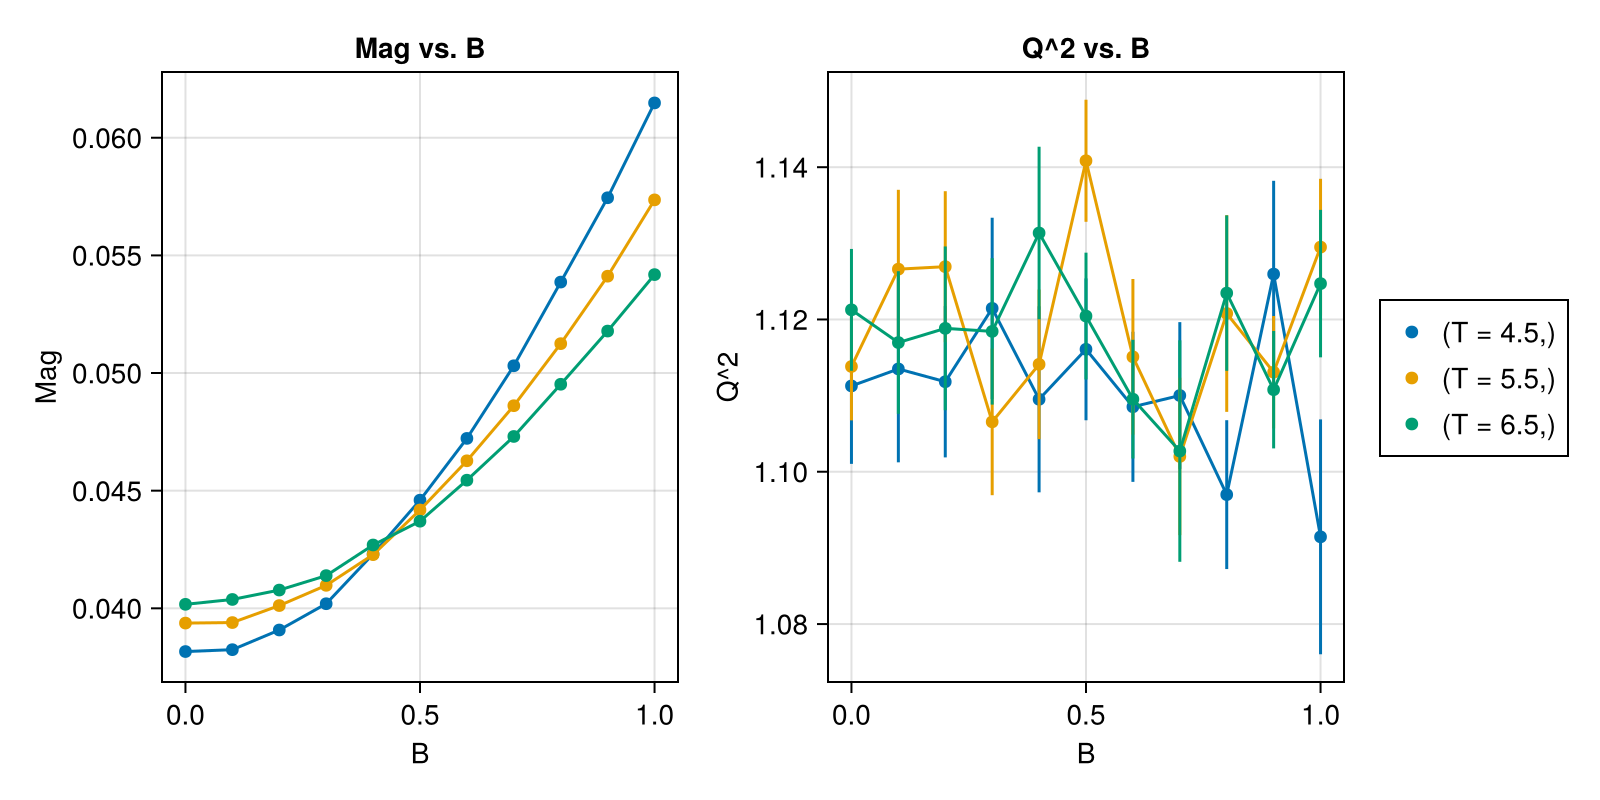

In [16]:
CairoMakie.activate!()
var1 = :Mag
fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. B", xlabel="B", ylabel="$var1")
generate_plot!(ax1, :B, var1, [:T], results.data; line=true)
fig[1,2] = ax2 = Axis(fig, title="Q^2 vs. B", xlabel="B", ylabel="Q^2")
generate_plot!(ax2, :B, :Q2, [:T], results.data; line=true)
Legend(fig[1,3], ax1)
fig

In [12]:
mctimes = get_mctime_data(results, :sk_half_M, :sk_corr_half_M, :Q, :Q2)
nothing

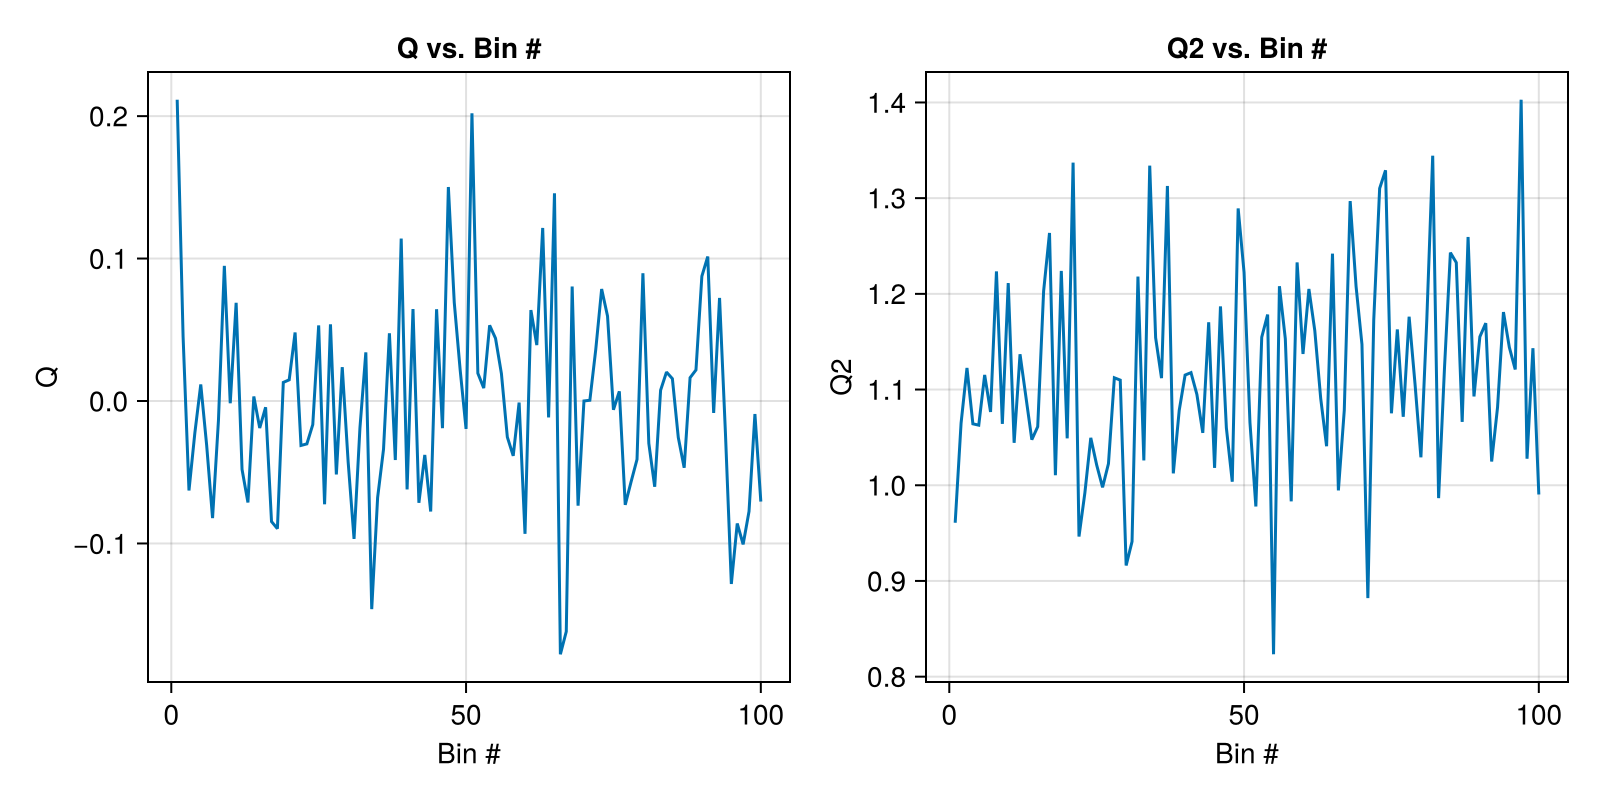

In [13]:
CairoMakie.activate!()
i = 25
var1 = :Q
var2 = :Q2

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
lines!(ax1, getindex.(mctimes[i][:, var1], 1))
lines!(ax2, getindex.(mctimes[i][:, var2], 1))
fig

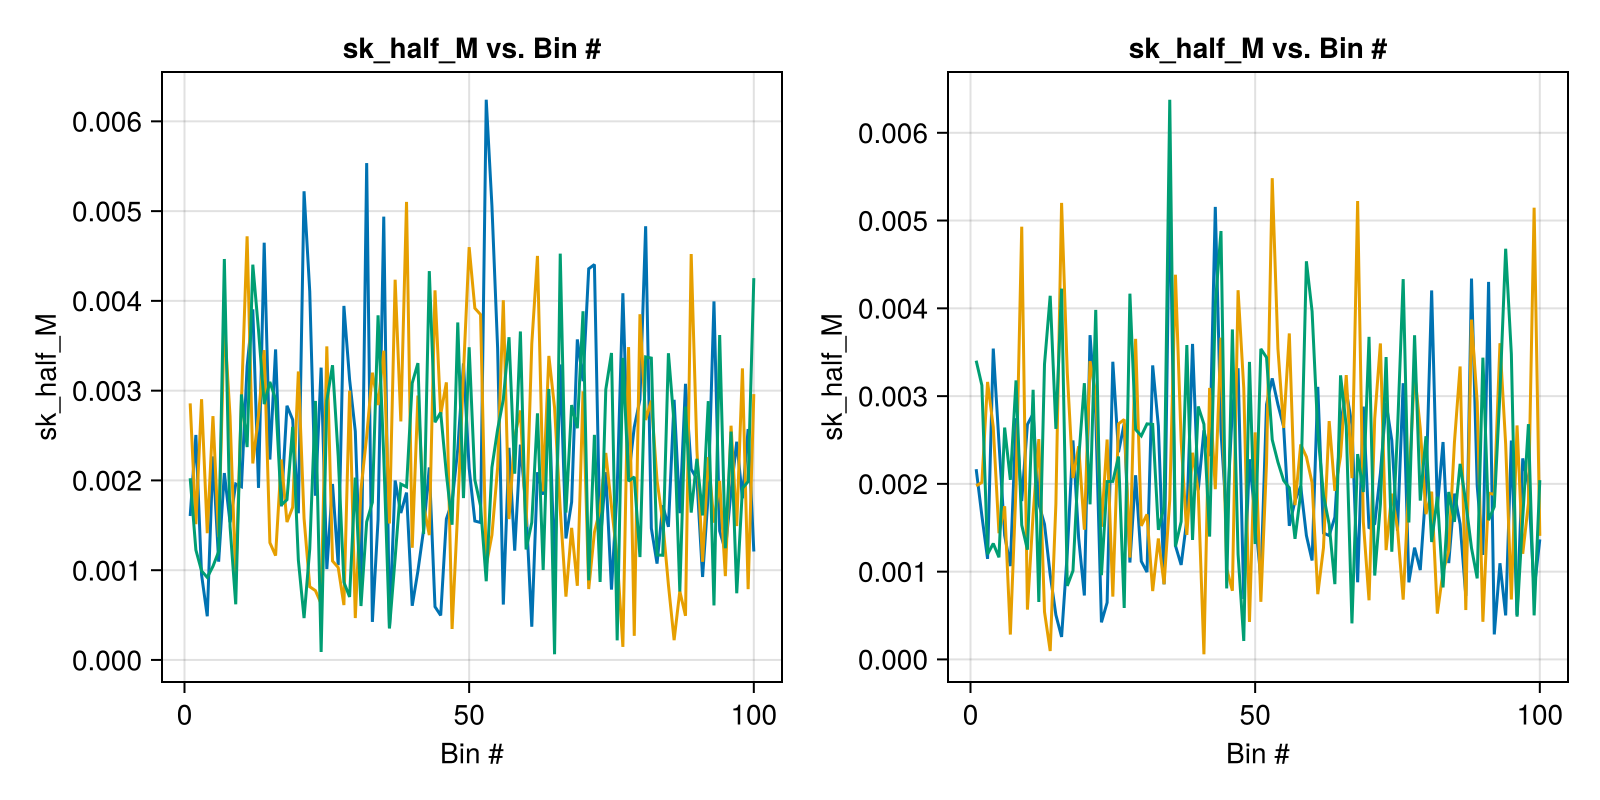

In [14]:
CairoMakie.activate!()
i = 12
var1 = :sk_half_M
var2 = :sk_half_M

fig = Figure(size=(800, 400))
fig[1,1] = ax1 = Axis(fig, title="$var1 vs. Bin #", xlabel="Bin #", ylabel="$var1")
fig[1,2] = ax2 = Axis(fig, title="$var2 vs. Bin #", xlabel="Bin #", ylabel="$var2")
for j in 1:3
    label = getindex(['x', 'y', 'z'], j)
    lines!(ax1, abs.(getindex.(mctimes[i][:, var1], j)); label)
    lines!(ax2, abs.(getindex.(mctimes[i+1][:, var2], j)); label)
end
fig